In [25]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer, TargetEncoder, OneHotEncoder, StandardScaler, QuantileTransformer
from dateutil.parser import parse
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import cv2
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model

In [2]:
df = pd.read_csv('./movie_dataset.csv', index_col=0)
df = df.drop(columns=['id', 'tagline', 'overview', 'vote_average', 'vote_count', 'domestic_opening', 'original_title', 'title', 'spoken_languages'])

df['budget'] = df['budget'].replace({0: np.NAN})
df['revenue'] = df['revenue'].replace({0: np.NAN})
df['runtime'] = df['runtime'].replace({0: np.NAN})

df.dropna(inplace=True)

df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

def get_class(row):
  R = row['revenue']
  B = row['budget']
  if R < B:
    return 0
  elif B <= R < 2*B:
    return 1
  elif 2*B <= R < 4*B:
    return 2
  elif 4*B <= R:
    return 3
  return np.NAN

df['target'] = df.apply(get_class, axis=1)

cont = ['runtime', 'budget']
categ = []
for col in df.columns:
  if col not in cont:
    categ.append(col)

literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']
for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(df['genres'])
classes = ['genre_' + x.replace(' ', '_').lower() for x in mlb.classes_]
df = df.join(pd.DataFrame(dum.astype(bool), df.index, classes))

genres = set(mlb.classes_)

df = df.drop(columns=['genres'], axis=1)

# Original language
df['original_language'] = df.apply(lambda row: 1 if row['original_language'] == 'en' else 0, axis=1)

# Production companies
def cumulative_revenue_replacer(column, iterable=True):
  entities = df[column].explode().tolist()
  entities_revenue = {}
  for e in entities:
    entities_revenue[e] = 0

  for index, row in df.iterrows():
    if iterable:
      for e in row[column]:
        entities_revenue[e] += row['revenue']
    else:
      entities_revenue[row[column]] += row['revenue']

  def entity_to_cumulative_revenue(entity):
    return entities_revenue[entity]

  def f(row):
    if iterable:
      return sum(list(map(entity_to_cumulative_revenue, row[column])))
    else:
      return entities_revenue[row[column]]

  return f

df['production_companies'] = df.apply(cumulative_revenue_replacer('production_companies'), axis=1)

# Production countries
df['production_countries'] = df.apply(cumulative_revenue_replacer('production_countries'), axis=1)

# Month
m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

one_hot_enc = OneHotEncoder(sparse_output=False)

mpaa_encoded = one_hot_enc.fit_transform(df[['release_month']])
classes = [f'release_month_{x}' for x in one_hot_enc.categories_[0]]
df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

# Domestic distributor
df['domestic_distributor'] = df.apply(cumulative_revenue_replacer('domestic_distributor', iterable=False), axis=1)

# MPAA
to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

one_hot_enc = OneHotEncoder(sparse_output=False)

mpaa_encoded = one_hot_enc.fit_transform(df[['mpaa']])
classes = [('mpaa_' + x.upper()) for x in one_hot_enc.categories_[0]]
df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

df = df.drop(columns=['mpaa'], axis=1)

# Actors
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)
df['actor_1'] = df.apply(cumulative_revenue_replacer('actor_1', iterable=False), axis=1)
df['actor_2'] = df.apply(cumulative_revenue_replacer('actor_2', iterable=False), axis=1)
df['actor_3'] = df.apply(cumulative_revenue_replacer('actor_3', iterable=False), axis=1)

# Director
df['director'] = df.apply(cumulative_revenue_replacer('director', iterable=False), axis=1)

# Delete target column
# df = df.drop(columns=['revenue'])

In [3]:
cont = cont + ['production_companies', 'production_countries', 'domestic_distributor', 'actor_1', 'actor_2', 'actor_3', 'director']
for col in cont:
    scaler = StandardScaler()
    # scaler = QuantileTransformer(output_distribution='normal', random_state=0)
    df[col] = scaler.fit_transform(df[[col]])

In [4]:
df = df.set_index('imdb_id')

posters = Path('./posters')
imdb_ids = [x.name[:-len('.jpg')] for x in posters.glob('*.jpg')]
df = df.loc[imdb_ids]
df['poster'] = df.apply(lambda x: f'./posters/{x.name}.jpg', axis=1)

df.reset_index(drop=False, inplace=True)

In [5]:
df.head()

,imdb_id,original_language,production_companies,production_countries,runtime,domestic_distributor,budget,revenue,director,poster,...,release_month_11,release_month_12,mpaa_G,mpaa_NC-17,mpaa_PG,mpaa_PG-13,mpaa_R,actor_1,actor_2,actor_3
0,tt0758766,1,-0.131917,0.274860,-0.671778,1.605222,0.074792,145896422,-0.278363,./posters/tt0758766.jpg,...,False,False,False,False,False,True,False,-0.217484,0.320978,-0.305987
1,tt0120620,1,1.108272,0.274860,-0.458909,1.171061,-0.284055,13000000,-0.510203,./posters/tt0120620.jpg,...,False,False,False,False,False,True,False,-0.585641,0.604143,0.535100
2,tt1524137,1,2.030633,0.926657,0.020046,0.828265,-0.284055,63100000,-0.210932,./posters/tt1524137.jpg,...,False,False,False,False,False,False,True,1.433292,0.604143,0.584023
3,tt0117011,1,0.408340,0.274860,-0.458909,0.517515,-0.284055,51702483,-0.527004,./posters/tt0117011.jpg,...,False,False,False,False,False,False,True,-0.324633,-0.558766,-0.467404
4,tt4094724,1,1.263768,0.410881,-0.192823,0.828265,-0.642901,118587880,-0.285501,./posters/tt4094724.jpg,...,False,False,False,False,False,False,True,-0.613063,-0.491297,-0.352994


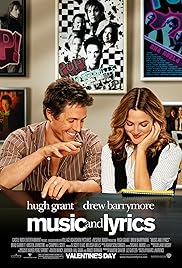

In [6]:
from PIL import Image

img = Image.open(df.loc[0].poster)
img

In [7]:
# import cv2

# face_image = cv2.resize(img, (48,48))
# face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
# face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 3])
# face_image

In [8]:
target = df['target']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target), y=target)
class_weights = {i: x for i, x in enumerate(class_weights)}
y = to_categorical(target)

P = []
for p in df['poster']:
    img = image.load_img(p)
    img = image.img_to_array(img)
    img = cv2.resize(img, (48,48))
    P.append(img)
P = np.array(P)

T = df.drop(columns=['imdb_id', 'revenue', 'poster', 'target'], axis=1).values.astype(float)

In [9]:
_, depth, height, width = P.shape

In [10]:
T_train, T_dum, P_train, P_dum, y_train, y_dum = train_test_split(
    T, P, y,
    test_size=0.1, 
    stratify=y,
)

T_val, T_test, P_val, P_test, y_val, y_test = train_test_split(
    T_dum, P_dum, y_dum,
    test_size=0.5,
    stratify=y_dum,
)

In [11]:
T.shape

(3852, 47)

In [29]:
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 20 # we iterate 200 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the dense layer with probability 0.5
hidden_size = 256 # the dense layer will have 512 neurons
num_classes = 4

def get_poster_model(depth, height, width):
    inp = Input(shape=(depth, height, width)) # N.B. depth goes first in Keras

    # Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)

    conv_1 = Convolution2D(conv_depth_1, kernel_size, activation='relu')(inp)

    conv_2 = Convolution2D(conv_depth_1, kernel_size, activation='relu')(conv_1)

    pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)

    drop_1 = Dropout(drop_prob_1)(pool_1)

    # Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)

    conv_3 = Convolution2D(conv_depth_2, kernel_size, activation='relu')(drop_1)

    conv_4 = Convolution2D(conv_depth_2, kernel_size, activation='relu')(conv_3)

    pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)

    drop_2 = Dropout(drop_prob_1)(pool_2)

    # Now flatten to 1D, apply Dense -> ReLU (with dropout) -> softmax

    flat = Flatten()(drop_2)

    hidden = Dense(hidden_size, activation='relu', name='last_fc_layer')(flat)

    drop_3 = Dropout(drop_prob_2)(hidden)

    out = Dense(num_classes, activation='softmax')(drop_3)

    return Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

poster_model = get_poster_model(depth, height, width)
# poster_model.summary()

poster_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

# Настриваем сохранение лучшей модели
checkpoint_path = "./best-poster-model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Настраиваем callback для ранней остановки модели
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=1)
# Настраиваем callback для TensorBoard
# tensorboard = TensorBoard(log_dir="./logs")

# Обучение модели
full_poster_history = poster_model.fit(
    P_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(P_val, y_val),
    class_weight=class_weights,
    verbose=1,
    callbacks=[
        checkpoint,
        early_stopping,
        # tensorboard,
    ],
)

# Загрузка лучшей модели
poster_best_model = load_model(checkpoint_path)
# Проверка лучшей модели
# inspect_model(best_model)

Epoch 1/20
108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2521 - loss: 15.6912
Epoch 1: val_accuracy improved from -inf to 0.21762, saving model to ./best-poster-model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.2520 - loss: 15.4967 - val_accuracy: 0.2176 - val_loss: 1.3870
Epoch 2/20
108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2906 - loss: 1.3788
Epoch 2: val_accuracy did not improve from 0.21762
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.2906 - loss: 1.3789 - val_accuracy: 0.2073 - val_loss: 1.3891
Epoch 3/20
108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2247 - loss: 1.3875
Epoch 3: val_accuracy improved from 0.21762 to 0.32124, saving model to ./best-poster-model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.2249 - loss: 1.3874 - val_accuracy: 0.3212 - val_loss: 1.3862
Epoch 4/20
108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2626 - loss: 1.3815
Epoch 4: val_accuracy did not improve from 0.3212

In [37]:
type(P_train)

numpy.ndarray

In [39]:
def get_tabular_model(input_shape, num_classes):
    tabular_input = Input(shape=input_shape)
    
    poster_best_model.trainable=False
    poster_output = poster_best_model.get_layer("last_fc_layer").output
    
    merge_layer = concatenate([tabular_input, poster_output])
    hidden = Dense(32, activation='relu')(merge_layer)
    hidden = Dense(64, activation='relu')(hidden)
    hidden = Dense(128, activation='relu')(hidden)
    hidden = Dense(64, activation='relu')(hidden)
    hidden = Dense(32, activation='relu')(hidden)
    output = Dense(num_classes, activation='softmax')(hidden)

    poster_input = poster_best_model.input
    model = Model(inputs=[tabular_input, poster_input], outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

tabular_model = get_tabular_model((T_train.shape[1],), 4)
tabular_model.summary()

# Настриваем сохранение лучшей модели
checkpoint_path = "./best-tabular-model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Настраиваем callback для ранней остановки модели
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=5, verbose=1)
# Настраиваем callback для TensorBoard
# tensorboard = TensorBoard(log_dir="./logs")

train = [T_train, P_train]
val = [T_val, P_val]

# Обучение модели
full_tabular_history = tabular_model.fit(
    train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(val, y_val),
    class_weight=class_weights,
    verbose=1,
    callbacks=[
        checkpoint,
        early_stopping,
        # tensorboard,
    ],
)

# Загрузка лучшей модели
tabular_best_model = load_model(checkpoint_path)
# Проверка лучшей модели
# inspect_model(best_model)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 46, 46,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 44, 44,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 22, 22,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 22, 22,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 20,    │     18,496 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 18, 18,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 9, 9, 64)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 9, 9, 64)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5184)      │          0 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_fc_layer       │ (None, 256)       │  1,327,360 │ flatten_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 303)       │          0 │ input_layer_9[0]… │
│ (Concatenate)       │                   │            │ last_fc_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 32)        │      9,728 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 64)        │      2,112 │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 128)       │      8,320 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 64)        │      8,256 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 32)        │      2,080 │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 4)         │        132 │ dense_48[0][0]    │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,423,556 (5.43 MB)

 Trainable params: 30,628 (119.64 KB)

 Non-trainable params: 1,392,928 (5.31 MB)

Epoch 1/50
213/217 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3340 - loss: 1.3644
Epoch 1: val_accuracy improved from -inf to 0.34715, saving model to ./best-tabular-model.keras
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3347 - loss: 1.3639 - val_accuracy: 0.3472 - val_loss: 1.3507
Epoch 2/50
215/217 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4384 - loss: 1.2722
Epoch 2: val_accuracy improved from 0.34715 to 0.40933, saving model to ./best-tabular-model.keras
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4384 - loss: 1.2721 - val_accuracy: 0.4093 - val_loss: 1.3223
Epoch 3/50
215/217 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4560 - loss: 1.2058
Epoch 3: val_accuracy did not improve from 0.40933
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4558 - loss: 1.2061 - val_accuracy: 0.3938 - val_loss: 1.3237
Epoch 4/50
213/217 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4619 - loss: 1.1916
Epoch 4: val_accuracy improved from 0.40933 to 0.440

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Функция для оценки полученной модели
def inspect_model(model):
  results = model.evaluate(T_test, y_test, batch_size=128)
  print('test loss, test acc:', results)

  predictions = model.predict(T_test)
  matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
  ConfusionMatrixDisplay(matrix).plot()

In [23]:
best_model.trainable=False